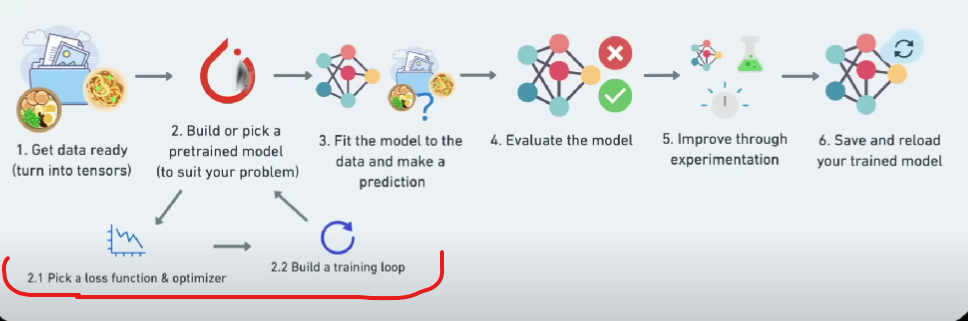

#### *Getting Data ready*

In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000
X,y=make_circles(n_samples,noise=0.02,random_state=42)

In [3]:
import pandas as pd
circles = pd.DataFrame({
    "X1":X[:,0],
    "X2":X[:,1],
    "label":y
        })

In [4]:
circles

,X1,X2,label
0,0.760266,0.223878,1
1,-0.767222,0.145542,1
2,-0.808159,0.148944,1
3,-0.376028,0.703209,1
4,0.440510,-0.897617,0
...,...,...,...
995,0.241536,0.953294,0
996,-0.975298,-0.264479,0
997,-0.141235,-0.801951,1
998,0.675090,-0.754657,0


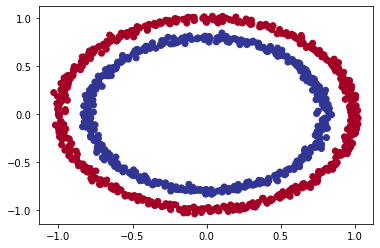

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],y=X[:,1],c=y, cmap=plt.cm.RdYlBu)

#### Turning the data into tensors 

In [6]:
import torch 
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

Its important to convert our data into float32 to prevent further errors in torch numpy has float64 type

In [7]:
X[:5], y[:5]

(tensor([[ 0.7603,  0.2239],
         [-0.7672,  0.1455],
         [-0.8082,  0.1489],
         [-0.3760,  0.7032],
         [ 0.4405, -0.8976]]),
 tensor([1., 1., 1., 1., 0.]))

#### Lets split the data

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test =train_test_split(X,y,train_size=0.7,random_state=42)

In [9]:
len(X_train)

700

In [10]:
len(X_test)

300

#### Building our model 

In [11]:
import torch 
from torch import nn

In [12]:
device = "cpu"
torch.cuda.is_available()

False

In [13]:
#We are going to first use nn.Linear() fro the kind of shapes we are having 
class Circle_modelv0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x):
        return self.layer2(self.layer1(x))


model0= Circle_modelv0().to(device)

In [14]:
## We can also replicate this with our nn.Sequential 

model_1= nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4268,  0.0518],
                      [-0.4470,  0.1004],
                      [-0.0771,  0.3071],
                      [-0.2054, -0.3382],
                      [ 0.6918,  0.1738]])),
             ('0.bias', tensor([-0.5451, -0.4683, -0.6940,  0.4741,  0.3732])),
             ('1.weight',
              tensor([[ 0.2258,  0.1579,  0.0873, -0.1446, -0.0487]])),
             ('1.bias', tensor([0.0614]))])

### Choosing Optimizer/Loss function

##### ->Stochastic Gradient Descent (SGD) optimizer ----> Classification, regression, many others.--->`torch.optim.SGD()`
##### -> Adam Optimizer-->Classification, regression, many others.->`torch.optim.Adam()`
##### -> Binary cross entropy loss---->Binary classification--->`torch.nn.BCELossWithLogits` or `torch.nn.BCELoss`
##### -> Cross entropy loss---->Multi-class classification---->`torch.nn.CrossEntropyLoss`
##### -> Mean absolute error (MAE) or L1 Loss  ----> Regression--->`torch.nn.L1Loss`
##### -> Mean squared error (MSE) or L2 Loss ---> Regression--->`torch.nn.MSELoss`

In [16]:
## For now lets use Binary cross entropy which has sigmoid activation
loss_fn = nn.BCEWithLogitsLoss()

optimizer= torch.optim.SGD(params=model_1.parameters(),lr=0.05)

In [17]:
def accuracy(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc
    

In [18]:
y_logits= model_1(X_test)
y_probs = torch.sigmoid(y_logits)
y_labels=torch.round(y_probs)
print(y_labels[:5].squeeze()[:5]==y_test[:5])
print(y_labels[:5])


tensor([False,  True, False,  True, False])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SliceBackward0>)


In [19]:
epochs=100
epoch=1
def epoch_loop(n_epochs):
    for epoch in range(1,n_epochs+1):
        y_logits= model_1(X_train).squeeze()
        y_probs = torch.sigmoid(y_logits)
        y_labels=torch.round(y_probs).squeeze()
        #Loss function
        loss = loss_fn(y_logits, y_train)# Note that the BCEwithLogtsLoss requires raw logits as input
        train_acc = accuracy(y_true=y_train, y_pred=y_labels)
        # Loss zero grad 
        optimizer.zero_grad()
        # Backward propagation
        loss.backward()
        # optimizer step(gradient descent)
        optimizer.step()

        ### Test set
        model_1.eval()
        with torch.inference_mode():
            test_logits=model_1(X_test).squeeze()
            test_pred=torch.round(torch.sigmoid(test_logits))

            # test loss and accuracy
            test_loss = loss_fn(test_logits, y_test)
            test_acc= accuracy(y_true= y_test, y_pred=test_pred)
            if epoch % 10==0 :
                print(f"Epoch:{epoch} |  Loss : {loss:.5f}  | Accuracy :{train_acc:.2f} | test loss :{test_loss}  | test accuracy :{test_acc}")
        epoch+=1
epoch_loop(n_epochs=epochs)

Epoch:10 |  Loss : 0.70002  | Accuracy :49.14 | test loss :0.6955512762069702  | test accuracy :52.0
Epoch:20 |  Loss : 0.69669  | Accuracy :49.14 | test loss :0.6941056251525879  | test accuracy :52.0
Epoch:30 |  Loss : 0.69491  | Accuracy :49.14 | test loss :0.6936436891555786  | test accuracy :52.0
Epoch:40 |  Loss : 0.69395  | Accuracy :42.71 | test loss :0.6936201453208923  | test accuracy :42.333333333333336
Epoch:50 |  Loss : 0.69343  | Accuracy :47.29 | test loss :0.6937708854675293  | test accuracy :46.666666666666664
Epoch:60 |  Loss : 0.69315  | Accuracy :49.43 | test loss :0.6939719915390015  | test accuracy :48.0
Epoch:70 |  Loss : 0.69300  | Accuracy :50.57 | test loss :0.6941684484481812  | test accuracy :47.0
Epoch:80 |  Loss : 0.69292  | Accuracy :51.57 | test loss :0.6943389773368835  | test accuracy :48.333333333333336
Epoch:90 |  Loss : 0.69287  | Accuracy :52.29 | test loss :0.6944785118103027  | test accuracy :48.333333333333336
Epoch:100 |  Loss : 0.69285  | Accu

In [20]:
import requests
import torchvision
from pathlib import Path
if Path("helper_functions.py").is_file():
    print("Wohoo is is there!!")
else:
    request= requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

Wohoo is is there!!


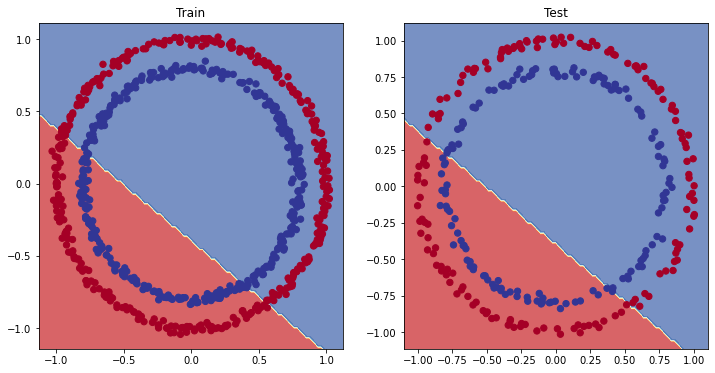

In [21]:
### VISUALIZING THE MODEL !!!!
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

 #### Improving the model 
  1. Increasing the no. of layers
  2. Changing the activation function
  3. Changing the optimizer function
  4. Changing the learning rate 
  5. Increasing the training time
  
  In a way we have to find out the perfect values for these , just haphazourdously increasing their values may lead to other problems like overfitting.

In [22]:
 model_2= nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=5),
    nn.Linear(in_features=5, out_features=1)).to(device)

model_2

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=5, bias=True)
  (2): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
loss_fn_1 = nn.BCEWithLogitsLoss()

optimizer_1= torch.optim.SGD(params=model_2.parameters(),lr=0.3)

In [24]:
epochs=1000
epoch=1
def epoch_loop_1(n_epochs):
    for epoch in range(1,n_epochs+1):
        y_logits = model_2(X_train).squeeze()
        y_probs = torch.sigmoid(y_logits)
        y_labels=torch.round(y_probs).squeeze()
        #Loss function
        loss = loss_fn_1(y_logits, y_train)# Note that the BCEwithLogtsLoss requires raw logits as input
        train_acc = accuracy(y_true=y_train, y_pred=y_labels)
        # Loss zero grad 
        optimizer_1.zero_grad()
        # Backward propagation
        loss.backward()
        # optimizer step(gradient descent)
        optimizer_1.step()

        ### Test set
        model_2.eval()
        with torch.inference_mode():
            test_logits=model_2(X_test).squeeze()
            test_pred=torch.round(torch.sigmoid(test_logits))

            # test loss and accuracy
            test_loss = loss_fn(test_logits, y_test)
            test_acc= accuracy(y_true= y_test, y_pred=test_pred)
            if epoch % 100==0 :
                print(f"Epoch:{epoch} |  Loss : {loss:.5f}  | Accuracy :{train_acc:.2f} | test loss :{test_loss}  | test accuracy :{test_acc}")
        epoch+=1
epoch_loop_1(n_epochs=epochs)

Epoch:100 |  Loss : 0.69286  | Accuracy :54.29 | test loss :0.6950940489768982  | test accuracy :49.666666666666664
Epoch:200 |  Loss : 0.69279  | Accuracy :53.86 | test loss :0.6951694488525391  | test accuracy :51.0
Epoch:300 |  Loss : 0.69279  | Accuracy :53.43 | test loss :0.6952086687088013  | test accuracy :51.33333333333333
Epoch:400 |  Loss : 0.69279  | Accuracy :53.43 | test loss :0.6952222585678101  | test accuracy :51.66666666666667
Epoch:500 |  Loss : 0.69279  | Accuracy :53.43 | test loss :0.6952270865440369  | test accuracy :51.66666666666667
Epoch:600 |  Loss : 0.69279  | Accuracy :53.43 | test loss :0.6952289342880249  | test accuracy :51.66666666666667
Epoch:700 |  Loss : 0.69279  | Accuracy :53.43 | test loss :0.6952296495437622  | test accuracy :51.66666666666667
Epoch:800 |  Loss : 0.69279  | Accuracy :53.43 | test loss :0.6952298879623413  | test accuracy :51.66666666666667
Epoch:900 |  Loss : 0.69279  | Accuracy :53.43 | test loss :0.6952300071716309  | test accur

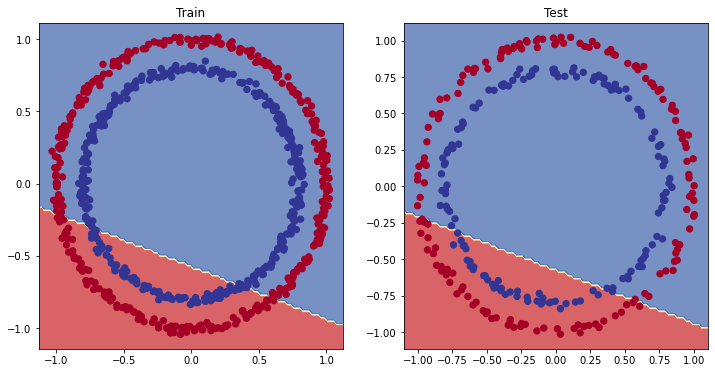

In [25]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)



#### See in these type of cases Linearity cannot solve oyr problems as u can see . Our model is almost guessing instead of predicting. 
#### This problem is solved by Non-linear functions. For ex- Sigmoid, ReLu etc 

In [26]:
## Lets build a model with non linear functions
from torch import nn 
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
        
model_3 = CircleModel().to(device) 
model_3
        
        
    

CircleModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [30]:
optimizer= torch.optim.SGD(model_3.parameters(),lr=0.1)

In [31]:
epochs=1000
def train_test_loop(n_epochs=epochs):
    for epoch in range(1,n_epochs+1):
        model_3.train()
        y_logits = model_3(X_train).squeeze()
        y_labels = torch.round(torch.sigmoid(y_logits))
        loss=loss_fn(y_logits, y_train)
        train_acc = accuracy(y_true=y_train, y_pred=y_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model_3.eval()
        with torch.inference_mode():
                test_logits=model_3(X_test).squeeze()
                test_pred=torch.round(torch.sigmoid(test_logits))

                # test loss and accuracy
                test_loss = loss_fn(test_logits, y_test)
                test_acc= accuracy(y_true= y_test, y_pred=test_pred)
                if epoch % 100==0 :
                    print(f"Epoch:{epoch} |  Loss : {loss:.5f}  | Accuracy :{train_acc:.2f} | test loss :{test_loss}  | test accuracy :{test_acc}")
        epoch+=1

train_test_loop()
    

Epoch:100 |  Loss : 0.67262  | Accuracy :79.71 | test loss :0.6739690899848938  | test accuracy :75.33333333333333
Epoch:200 |  Loss : 0.66231  | Accuracy :80.43 | test loss :0.6640341281890869  | test accuracy :76.66666666666667
Epoch:300 |  Loss : 0.64666  | Accuracy :82.00 | test loss :0.6482383608818054  | test accuracy :78.33333333333333
Epoch:400 |  Loss : 0.62144  | Accuracy :90.57 | test loss :0.6230234503746033  | test accuracy :88.33333333333333
Epoch:500 |  Loss : 0.57861  | Accuracy :97.86 | test loss :0.5814195871353149  | test accuracy :95.66666666666667
Epoch:600 |  Loss : 0.50770  | Accuracy :98.00 | test loss :0.51418137550354  | test accuracy :98.33333333333333
Epoch:700 |  Loss : 0.40356  | Accuracy :98.71 | test loss :0.4155675768852234  | test accuracy :98.33333333333333
Epoch:800 |  Loss : 0.28179  | Accuracy :99.29 | test loss :0.294301301240921  | test accuracy :99.33333333333333
Epoch:900 |  Loss : 0.17628  | Accuracy :100.00 | test loss :0.18818049132823944  |

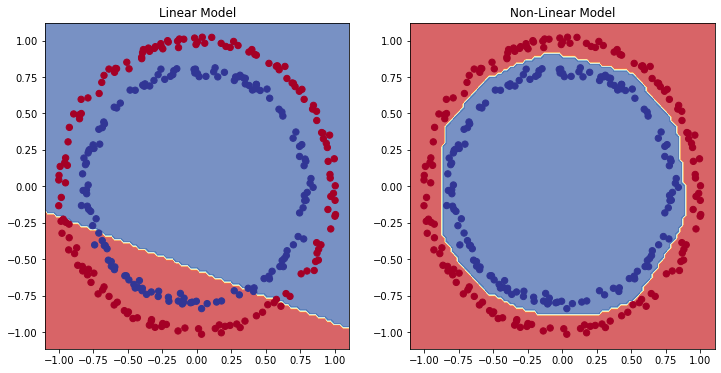

In [33]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Linear Model")
plot_decision_boundary(model_2, X_test, y_test)
plt.subplot(1,2,2)
plt.title("Non-Linear Model")
plot_decision_boundary(model_3, X_test, y_test)

##             WE GOT 100% ACCURACY !!!

I actually ran the loop twice , on the first loop accuracy was about 60-70 , but on 2nd loop its 100 !!